In [8]:
# 두개의 박스가 서로 교차하는지를 판단하는 함수
def _is_box_intersect(box1, box2):
    if (
        abs(box1[0] - box2[0]) < box1[2] / 2 + box2[2] / 2
        and abs(box1[1] - box2[1]) < box1[3] / 2 + box2[3] / 2
    ):
        return True
    else:
        return False


# 박스의 영역을 계산하는 박스 box의 좌표 체계는 [center_x, center_y, width, height] 이고, 상대 좌표 (YOLO 라벨링 방법임)
def _get_area(box):  # area of box n.
    return box[2] * box[3]


# 교집합의 영역을 구하는 함수
def _get_intersection_area(box1, box2):
    return abs(max(box1[0], box2[0]) - min(box1[0] + box1[2], box2[0] + box2[2])) * abs(
        max(box1[1], box2[1]) - min(box1[1] + box1[3], box2[1] + box2[3])
    )


# 합집합의 영역을 구하는 함수
def _get_union_area(box1, box2, inter_area=None):
    area_a = _get_area(box1)
    area_b = _get_area(box2)
    if inter_area is None:
        inter_area = _get_intersection_area(box1, box2)

    return float(area_a + area_b - inter_area)


# IOU를 계산하는 함수
def iou(box1, box2):
    # if boxes do not intersect
    if _is_box_intersect(box1, box2) is False:
        return 0

    inter_area = _get_intersection_area(box1, box2)
    union = _get_union_area(box1, box2, inter_area=inter_area)

    # intersection over union
    iou = inter_area / union
    if iou < 0:
        iou = 0
    assert iou >= 0, f"Measure is wrong! : IoU Value is [{iou}]."
    return iou

In [9]:
box1 = (0.3, 0.3, 0.1, 0.1)
box2 = (0.31, 0.28, 0.14, 0.13)

print(iou(box1, box2))

0.46875000000000044


In [10]:
# NMS 시각화
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 두개의 박스가 서로 교차하는지를 판단하는 함수
def _is_box_intersect(box1, box2):
    return (
        abs(box1[0] - box2[0]) < box1[2] + box2[2]
        and abs(box1[1] - box2[1]) < box1[3] + box2[3]
    )


def _get_area(box):
    return box[2] * box[3]


def _get_intersection_area(box1, box2):
    return abs(max(box1[0], box2[0]) - min(box1[0] + box1[2], box2[0] + box2[2])) * abs(
        max(box1[1], box2[1]) - min(box1[1] + box1[3], box2[1] + box2[3])
    )


def _get_union_area(box1, box2, inter_area=None):
    area_a = _get_area(box1)
    area_b = _get_area(box2)
    if inter_area is None:
        inter_area = _get_intersection_area(box1, box2)
    return float(area_a + area_b - inter_area)


def iou(box1, box2):
    if not _is_box_intersect(box1, box2):
        return 0
    inter_area = _get_intersection_area(box1, box2)
    union = _get_union_area(box1, box2, inter_area=inter_area)
    iou_val = inter_area / union
    return max(iou_val, 0)


def nms(boxes, iou_thres=0.4):
    elems = np.array(boxes)
    print("\nBefore Araange")
    print(elems)

    # 넘파이의 argsort를 통해서 정렬 수행
    sorted_index = np.argsort(elems[:, -1])[::-1]
    sorted_boxes = elems[sorted_index]

    print("\nAfter Arrange")
    print(sorted_boxes)

    answer = [True for _ in range(sorted_boxes.shape[0])]
    print("\nBefore NMS Answer :", answer)

    for i in range(sorted_boxes.shape[0]):
        if not answer[i]:
            continue
        for j in range(i + 1, sorted_boxes.shape[0]):
            iou_val = iou(sorted_boxes[i], sorted_boxes[j])
            print(f"{i} vs {j} = iou {round(iou_val, 3)}")
            if iou_val >= iou_thres:
                answer[j] = False
                print(f"Index {j} is False.")
    print("\nAfter NMS Answer :", answer)
    return answer, sorted_boxes, sorted_index


Before Araange
[[0.3  0.3  0.1  0.1  0.9 ]
 [0.31 0.28 0.14 0.13 0.5 ]
 [0.28 0.28 0.09 0.11 0.3 ]
 [0.75 0.65 0.2  0.2  0.99]
 [0.7  0.63 0.22 0.18 0.35]
 [0.75 0.62 0.22 0.22 0.77]]

After Arrange
[[0.75 0.65 0.2  0.2  0.99]
 [0.3  0.3  0.1  0.1  0.9 ]
 [0.75 0.62 0.22 0.22 0.77]
 [0.31 0.28 0.14 0.13 0.5 ]
 [0.7  0.63 0.22 0.18 0.35]
 [0.28 0.28 0.09 0.11 0.3 ]]

Before NMS Answer : [True, True, True, True, True, True]
0 vs 1 = iou 0
0 vs 2 = iou 0.754
Index 2 is False.
0 vs 3 = iou 0
0 vs 4 = iou 0.519
Index 4 is False.
0 vs 5 = iou 0
1 vs 2 = iou 0
1 vs 3 = iou 0.469
Index 3 is False.
1 vs 4 = iou 0
1 vs 5 = iou 0.463
Index 5 is False.

After NMS Answer : [True, True, False, False, False, False]


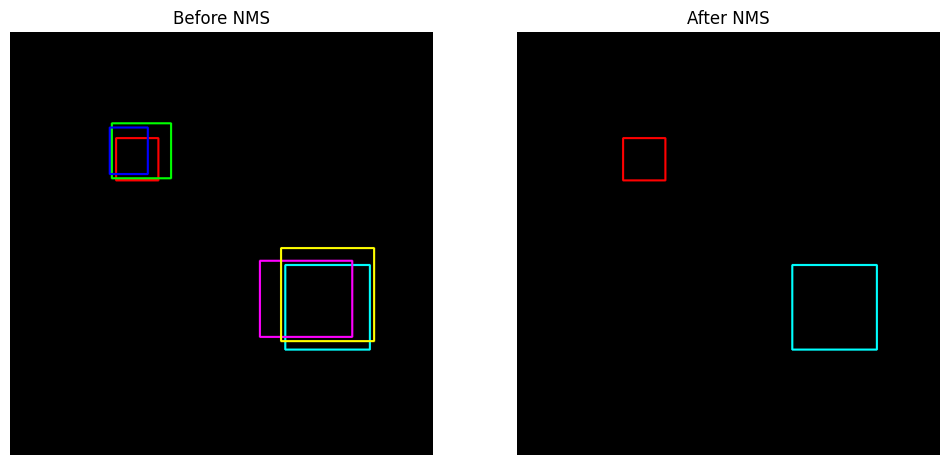

In [11]:
colorset = [
    (0, 0, 255),
    (0, 255, 0),
    (255, 0, 0),
    (255, 255, 0),
    (255, 0, 255),
    (0, 255, 255),
]

boxes = [
    [0.3, 0.3, 0.1, 0.1, 0.9],
    [0.31, 0.28, 0.14, 0.13, 0.5],
    [0.28, 0.28, 0.09, 0.11, 0.3],
    [0.75, 0.65, 0.2, 0.2, 0.99],
    [0.7, 0.63, 0.22, 0.18, 0.35],
    [0.75, 0.62, 0.22, 0.22, 0.77],
]

width, height = 600, 600
canvas = np.zeros((width, height, 3), dtype=np.uint8)
canvas_copy = canvas.copy()

for index, box in enumerate(boxes):
    pt1 = (int(width * (box[0] - box[2] / 2)), int(height * (box[1] - box[3] / 2)))
    pt2 = (int(width * (box[0] + box[2] / 2)), int(height * (box[1] + box[3] / 2)))
    cv2.rectangle(canvas, pt1, pt2, colorset[index], 2)

answer, sorted_boxes, sorted_index = nms(boxes, iou_thres=0.4)

for index, (sbox, sidx) in enumerate(zip(sorted_boxes, sorted_index)):
    if answer[index]:
        pt1 = (
            int(width * (sbox[0] - sbox[2] / 2)),
            int(height * (sbox[1] - sbox[3] / 2)),
        )
        pt2 = (
            int(width * (sbox[0] + sbox[2] / 2)),
            int(height * (sbox[1] + sbox[3] / 2)),
        )
        cv2.rectangle(canvas_copy, pt1, pt2, colorset[sidx], 2)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
axs[0].set_title("Before NMS")
axs[0].axis("off")

axs[1].imshow(cv2.cvtColor(canvas_copy, cv2.COLOR_BGR2RGB))
axs[1].set_title("After NMS")
axs[1].axis("off")

plt.show()